## Social graphs & intercations
- Assignment 1
- Submission date: September 30th 2025

### Group 101
- Aryan Mirzazadeh - s204489
- Juan Manuel Rodriguez - s253505 
- Vladyslav Horbatenko - s254355

### Contributions

- Aryan: Primarily worked on the assignment 1.2
- Juan: Primarily worked on the assignment 1.1
- Vlad: Primarily worked on the assignment 1.2

# Assignment 1.1: Exploring WS and BA models

This first part draws on the Watts-Stogatz and Barabasi-Albert models from Week 3. You should provide solutions to the exercises with the following titles from **Part 1** 

* *Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook*

* *WS edition*



> **Exercise**:
> * What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?

In a large random network, the degree distribution follows a Poisson distribution. That means:

* Most nodes have a degree very close to the average ⟨k⟩.

* The probability of finding nodes with much higher degree drops faster than exponentially.

In real networks, however, we often see heavy-tailed degree distributions (often close to power-law). This implies:

* A significant fraction of nodes have very large degree (hubs).

* Random networks underestimate the likelihood of hubs and therefore cannot capture the heterogeneity found in real-world systems.

So the main problem: Random networks predict homogeneity of node degrees, but real networks are heterogeneous with hubs.

> **Exercise**:
> * List the four regimes that characterize random networks as a function of $\langle k \rangle$.

* **Subcritical Regime:** 0 < $\langle k \rangle$ > 1. Most nodes have fewer than one connection on average. The network consists only of small, isolated clusters with no giant component.

* **Critical Point:** $\langle k \rangle$ = 1 Most nodes are located in numerous small components and nodes are most likely to have only one link.

* **Supercritical Regime:** $\langle k \rangle$ > 1. A giant component emerges that contains a finite fraction of all nodes, coexisting with small isolated clusters.

* **Connected Regime:** $\langle k \rangle$ > lnN (p > lnN/N). With high probability, all nodes belong to a single connected component.

> **Exercise:**
> * According to the book, why is it a problem for random networks (in terms of being a model for real-world networks) that the degree-dependent clustering $C(k)$ decreases as a function of $k$ in real-world networks?

In random networks, the clustering coefficient C is constant and does not depend on the degree k. In real networks, C(k) decreases as k increases, and overall clustering is much higher than in a random network with the same N and L. This matters because real hubs act as bridges between tightly clustered communities, something random networks cannot capture.

Average shortest path length (p=0): 62.875751503006015
Average shortest path length (p=0.1): 7.844745490981964
Average shortest path length (p=1): 4.752833667334669


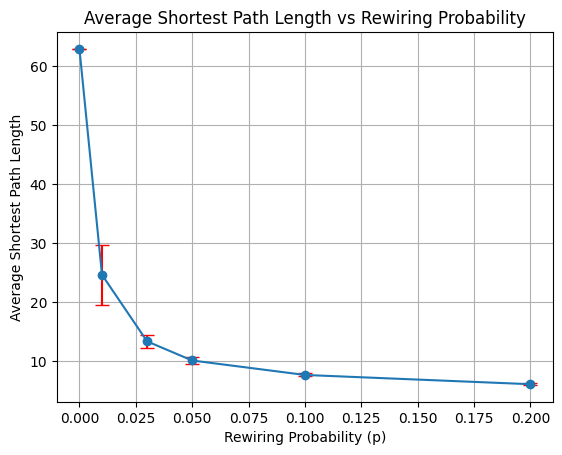

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# nx.watts_strogatz_graph used to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity p = 0, 0.1, and 1
watts_strogatz_graph_1 = nx.watts_strogatz_graph(500, 4, 0)
watts_strogatz_graph_2 = nx.watts_strogatz_graph(500, 4, 0.1)
# when p = 1, the graph is a random graph
watts_strogatz_graph_3 = nx.watts_strogatz_graph(500, 4, 1)

# print average shortest path lengths
print(
    "Average shortest path length (p=0):",
    nx.average_shortest_path_length(watts_strogatz_graph_1),
)
print(
    "Average shortest path length (p=0.1):",
    nx.average_shortest_path_length(watts_strogatz_graph_2),
)
print(
    "Average shortest path length (p=1):",
    nx.average_shortest_path_length(watts_strogatz_graph_3),
)
N = 500
k = 4
p = [0, 0.01, 0.03, 0.05, 0.1, 0.2]
avg_shortest_path_lengths = []
std_devs = []
# for each p, generate 50 graphs of 500 nodes and calculate the average shortest path length and its standard deviation
for prob in p:
    lengths = []
    for i in range(50):
        lengths.append(
            nx.average_shortest_path_length(nx.watts_strogatz_graph(N, k, prob))
        )
    avg_shortest_path_lengths.append(np.mean(lengths))
    std_devs.append(np.std(lengths))

# plot std´s as error bars with red color using plt.errorbar
plt.errorbar(
    p, avg_shortest_path_lengths, yerr=std_devs, fmt="-o", ecolor="red", capsize=5
)
plt.xlabel("Rewiring Probability (p)")
plt.ylabel("Average Shortest Path Length")
plt.title("Average Shortest Path Length vs Rewiring Probability")

plt.grid(True)
plt.show()

The figure shows the change in the shortest path increasing the number of p generated with the calculation of the avg shortest path of 50 graphs for each of these p´s: [0, 0.01, 0.03, 0.05, 0.1, 0.2] adding the standard deviation of the 50 graphs of each of the p´s in red color. The avg shortest path decreases with the increase of the rewiring probability until it becomes stable after a probability of 0.1


#### Assignment 1.1 **Part 2**

* *BA Edition*.
  * **Note**: The second part of this exercise (after the questions to the text) first has you build a BA network step-by-step, but doesn't ask any questions. For that part, I would simply like you to write well-documented code that shows how you build the network. 


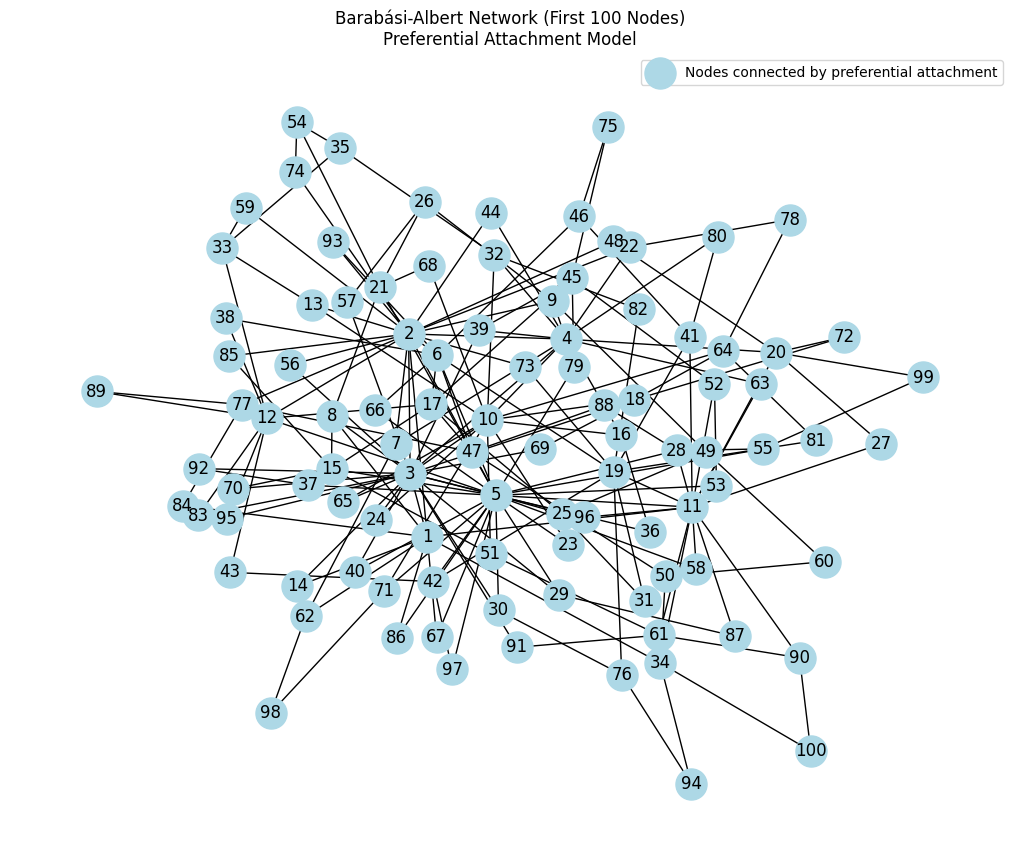

Number of nodes: 100
Number of nodes: 5000
Maximum degree: 168
Minimum degree: 2


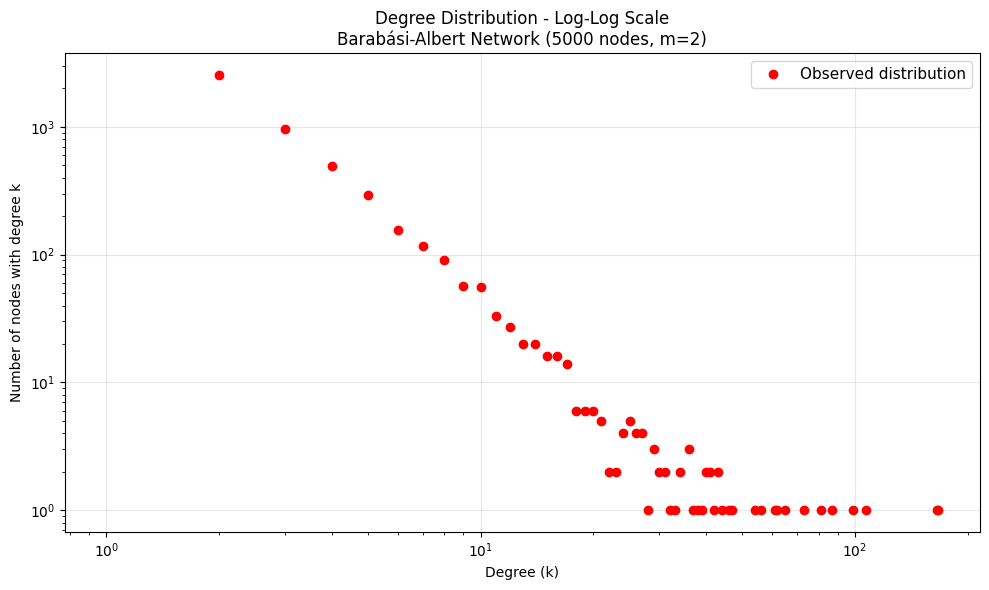

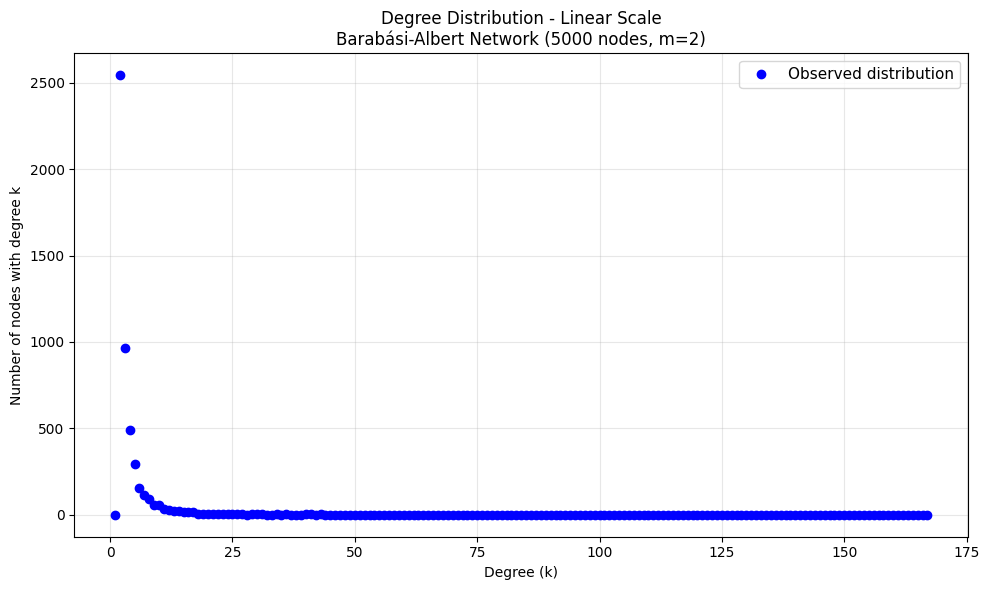

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
# import numpy as np

# graph on node 1
G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_edge(1, 2)


# add node following the preferential attachment model
def preferential_attachment(G, m, new_node):
    # m = number of edges each new node creates when it joins the network.
    degrees = dict(G.degree())
    total_degree = sum(degrees.values())

    # calculate the probability of each node or the proportion of connections of each node
    probabilities = [degrees[node] / total_degree for node in G.nodes()]
    # pick m nodes to which the new node will join based on proportion to its degree using np.random.choice
    new_nodes = np.random.choice(
        list(G.nodes()), size=m, replace=False, p=probabilities
    )
    # add the new node and edges to the graph according to the probabilities
    G.add_node(new_node)
    for node in new_nodes:
        G.add_edge(new_node, node)
    return new_nodes


for i in range(3, 101):
    # with m=2 every new node links to exactly 2 existing nodes as usually defined in the BA model
    preferential_attachment(G, 2, i)

# Visualize the initial network (first 100 nodes)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=500)
plt.title("Barabási-Albert Network (First 100 Nodes)\nPreferential Attachment Model")
plt.xlabel("Network visualization showing preferential attachment growth")
plt.legend(["Nodes connected by preferential attachment"])
plt.show()

print("Number of nodes:", G.number_of_nodes())

# Continue building the network to 5000 nodes
for i in range(101, 5001):
    # with m=2 every new node links to exactly 2 existing nodes as usually defined in the BA model
    preferential_attachment(G, 2, i)

# number of nodes
print("Number of nodes:", G.number_of_nodes())
# maximum degree
print("Maximum degree:", max([G.degree(n) for n in G.nodes()]))
# minimum degree
print("Minimum degree:", min([G.degree(n) for n in G.nodes()]))
# calculate the degree distribution
degrees = [G.degree(n) for n in G.nodes()]

# Plot degree distribution - Log-log scale
hist = np.histogram(degrees, bins=range(1, max(degrees) + 1))
plt.figure(figsize=(10, 6))
plt.loglog(
    hist[1][:-1],
    hist[0],
    marker="o",
    linestyle="None",
    color="red",
    markersize=6,
    label="Observed distribution",
)
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes with degree k")
plt.title(
    "Degree Distribution - Log-Log Scale\nBarabási-Albert Network (5000 nodes, m=2)"
)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Plot degree distribution - Linear scale
plt.figure(figsize=(10, 6))
plt.plot(
    hist[1][:-1],
    hist[0],
    marker="o",
    linestyle="None",
    color="blue",
    markersize=6,
    label="Observed distribution",
)
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes with degree k")
plt.title(
    "Degree Distribution - Linear Scale\nBarabási-Albert Network (5000 nodes, m=2)"
)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# add 10 nodes following the preferential attachment model


# Assignment 1.2: Stats and visualization of the Rock Music Network

*questions:*
1. Crawl wikipedia list of rock performers and then explain the process.
2. How were LLMs used in the exercise?
3. What we would do differently?
4. Network statistics and analysis
5. Network visualization (Part 3)

### Crawl Wikipedia

#### 1) Crawling process
1. Fetched the wiki page content of the list of rock performers by using the same strategy as week 1 exercises.
2. Used a regex pattern (`r"\[{2}([^#\[\]<>{}|_]*)[|#]?[^#\[\]<>{}|_]*\]{2}"`), to match the wikipedia reference formatting to find all of the artists. Afterwards, removed the false positives by creating an `ignore_matches` list to filter out false positives and non band matches. For example: `"Category:", "AllMusic", "rock music"`
3. Fetched the wiki page content of all the artist found in parallel and saved the content in txt files per artist. And loaded the data in a dictionary, ready to be used by `NetworkX`. Code for how we fetched data can be found in our [github](https://github.com/rifolio/dtu-projects-2025-autumn/blob/master/social-graphs/Assignment-1-rock-band-utils.ipynb)

#### 2) LLMs usage
We used LLMs, when our initial regex pattern was missing a couple of matches, since some of the bands had special characters in their names.

Also, we updated our initial fetching process (per artist), to be async and utilize 100 thread workers simultaneously. This reduced our fetching time from 4 minutes to 4-10 seconds.

#### 3) Crawling alternative choices
First of all, we should have discarded all text before "0-9" heading and after "References" heading when we fetched the list of rock performers. This would have prevented the need to check if the matches are actual bands or not.

Secondly, the the regex pattern could have been more specific, since all artists in the page are displayed in order in markdown format. This means that all exact artists can be found if we matched something like "\* \[\[artist name | (optional extra text)]]". This improvement by itself would have also prevented the need for checking the list for any non-related matches.

In [3]:
# Fetch and load the rock band graph from our GitHub repository
import json
import networkx as nx
import requests
import gzip
import io
import os

local_network = "data/rock_graph_node_link.json.gz"
raw_url = f"https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/{local_network}"
read_graph_kwargs = {"comments": "#", "delimiter": "|", "create_using": nx.DiGraph()}

if os.path.exists(local_network):
    with gzip.open("data/rock_graph_node_link.json.gz", "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
else:
    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()
    with gzip.open(io.BytesIO(r.content), "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
print(
    f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges.",
    f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
    sep="\n",
)

Loaded graph with 488 nodes and 7323 edges.
Graph component count: 5


### 4) Network Statistics Exercise

**Network Size & Links**:

The Network has 488 nodes and 7323 links.

However, 4 of those nodes were completely isolated. So, those nodes were removed (seen below) from the network before proceeding with the rest of the statistics.

The removal of isolated nodes, lets the graph to be a one single large component. So there is no need of further extraction.

In [4]:
# Remove isolated nodes from the graph
isolated_nodes = list(nx.isolates(G_bands))
G_bands.remove_nodes_from(isolated_nodes)
print(
    f"Removed {len(isolated_nodes)} isolated nodes.",
    G_bands,
    f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
    sep="\n",
)

Removed 4 isolated nodes.
DiGraph with 484 nodes and 7323 edges
Graph component count: 1


#### Degree distribution

**Questions:**
- Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?
- Compare the out-degree distribution to a *random network* with the same number of nodes and links.
- Compare the in-degree distribution to a *scale-free* network with the same number of nodes.

#### In-degree vs out-degree
- **In-degree distribution**: Heavily right-skewed distribution where most nodes have a  low in-degrees (0-20).
- **Out-degree distribution**: A more "normal" but still right skewed distribution where values are concentrated around (5-30).

The key difference stems from the fact that well-known bands get referenced more often, leading to a most popular bands have the highest in-degrees values as well. While out-degrees remain more constrained by the wikipedia page entries and editorial focus for each artist/band. This causes an upper bound on the out-degree and a higher concentration around 5-30 out-degree.

#### Comparison with Random Network (Out-degree)

The **random network** is a symmetric, bell-shaped distribution centered around the mean degree $\frac{7232}{484} = 15$. This is characteristic of random graphs where edges are placed uniformly at random.

**Differences:**
- **Rock bands**: Heavy concentration at lower out-degrees with a gradual decay
- **Random network**: Symmetric normal-like distribution around the mean
- **Interpretation**: Our network shows that most bands reference relatively few others, while random networks distribute connections more evenly

#### Comparison with Scale-free Network (In-degree)

**Differences:**
- **Scale-free**: More extreme with a steeper curve and higher peak at low degrees
- **Rock bands**: Similar shape but less extreme, with a more gradual downwards trend
- **Interpretation**: Our network is somewhat less extreme than the pure scale-free model. This suggests that while popularity matters for references, there are other factors (genre, era, geography, etc.) that influence referencing patterns on wikipedia.



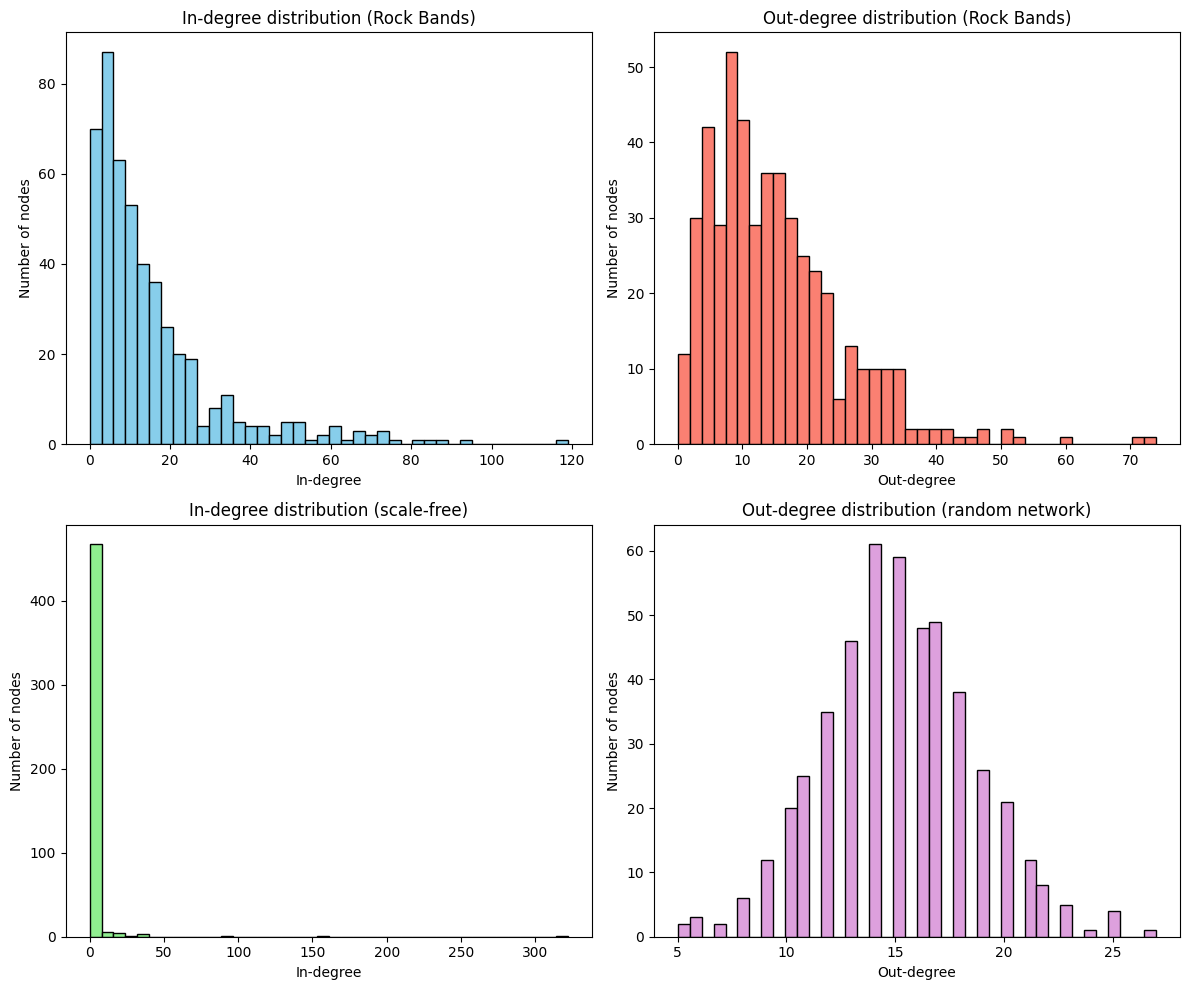

In [5]:
import matplotlib.pyplot as plt

bins = 40
y_axis_label = "Number of nodes"
in_degrees = dict(G_bands.in_degree())
out_degrees = dict(G_bands.out_degree())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].hist(
    list(in_degrees.values()), bins=bins, color="skyblue", edgecolor="black"
)
axes[0, 0].set_title("In-degree distribution (Rock Bands)")
axes[0, 0].set_xlabel("In-degree")
axes[0, 0].set_ylabel(y_axis_label)

axes[0, 1].hist(
    list(out_degrees.values()), bins=bins, color="salmon", edgecolor="black"
)
axes[0, 1].set_title("Out-degree distribution (Rock Bands)")
axes[0, 1].set_xlabel("Out-degree")
axes[0, 1].set_ylabel(y_axis_label)

sf = nx.scale_free_graph(G_bands.number_of_nodes(), seed=42)
sf_in = dict(sf.in_degree())

axes[1, 0].hist(list(sf_in.values()), bins=bins, color="lightgreen", edgecolor="black")
axes[1, 0].set_title("In-degree distribution (scale-free)")
axes[1, 0].set_xlabel("In-degree")
axes[1, 0].set_ylabel(y_axis_label)

rn = nx.gnm_random_graph(
    G_bands.number_of_nodes(), G_bands.number_of_edges(), seed=42, directed=True
)
rn_out = dict(rn.out_degree())

axes[1, 1].hist(list(rn_out.values()), bins=bins, color="plum", edgecolor="black")
axes[1, 1].set_title("Out-degree distribution (random network)")
axes[1, 1].set_xlabel("Out-degree")
axes[1, 1].set_ylabel(y_axis_label)

plt.tight_layout()
plt.show()


In [6]:
# Top 5 most connected bands (in-degree) and (out-degree)
top5_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
top5_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
# Top 10 bands with the longest wiki entries
top10_entries = sorted(
    [(band, data.get("content_length", 0)) for band, data in G_bands.nodes(data=True)],
    key=lambda x: x[1],
    reverse=True,
)[:10]

print("Top 5 bands by in-degree:")
for i, (band, degree) in enumerate(top5_in, 1):
    print(f"{i}. {band}: {degree}")

print("\nTop 5 bands by out-degree:")
for i, (band, degree) in enumerate(top5_out, 1):
    print(f"{i}. {band}: {degree}")


print("\nTop 10 bands with the longest wiki entries:")
for i, (band, length) in enumerate(top10_entries, 1):
    print(f"{i}. {band}: {length:,} chars")

Top 5 bands by in-degree:
1. Led Zeppelin: 119
2. Bob Dylan: 95
3. Queen (band): 88
4. Metallica: 85
5. David Bowie: 83

Top 5 bands by out-degree:
1. Alice in Chains: 74
2. Deep Purple: 71
3. Black Sabbath: 60
4. Def Leppard: 52
5. Guns N' Roses: 51

Top 10 bands with the longest wiki entries:
1. Guns N' Roses: 370,245 chars
2. Marilyn Manson (band): 295,602 chars
3. Coldplay: 294,838 chars
4. Queen (band): 285,019 chars
5. The Rolling Stones: 269,857 chars
6. Paul McCartney: 265,210 chars
7. Bob Dylan: 264,174 chars
8. U2: 263,343 chars
9. David Bowie: 261,246 chars
10. Elton John: 256,840 chars


In [7]:
# Convert to undirected graph + basic statistics
G_band_undirected = G_bands.to_undirected()
print(G_band_undirected)

Graph with 484 nodes and 6019 edges


## 5) Graph Visualization (Part 3)

In the code cell below, we have plotted the undirected rock band network using the Spring and Kamada Kawai layouts.

- Node colors are mapped to use the viridis sequntial color schema and dependent based on their content length attribute
- Node sizes are set to be dependent on the their degree

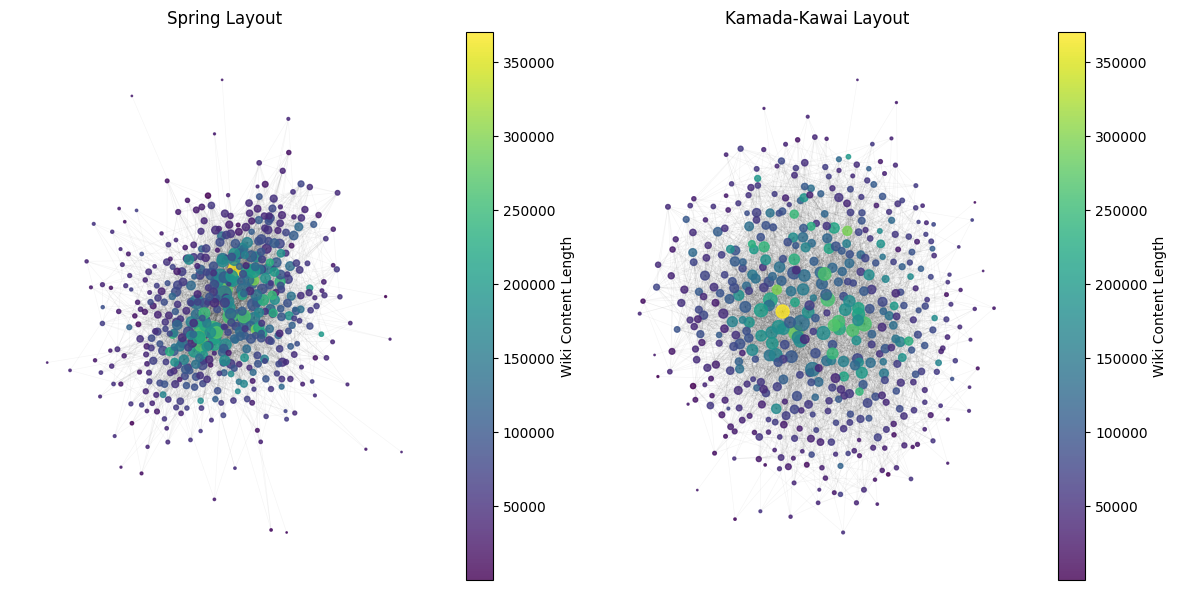

In [8]:
from matplotlib import cm

# Build node size and color arrays from node attributes
degrees = dict(G_band_undirected.degree())
node_sizes = [degrees[n] for n in G_band_undirected.nodes]
content_lengths = [
    G_band_undirected.nodes[n]["content_length"] for n in G_band_undirected.nodes
]

cmap = cm.viridis
nodes_kwargs = {
    "G": G_band_undirected,
    "node_size": node_sizes,
    "node_color": content_lengths,
    "cmap": cmap,
    "alpha": 0.8,
}
edges_kwargs = {
    "G": G_band_undirected,
    "alpha": 0.04,
    "width": 0.5,
}

# Spring Layout graph
plt.figure(figsize=(12, 6))
plt.subplot(121)
pos_spring = nx.spring_layout(G_band_undirected, seed=42)
nodes_spring = nx.draw_networkx_nodes(pos=pos_spring, **nodes_kwargs)
nx.draw_networkx_edges(pos=pos_spring, **edges_kwargs)
plt.title("Spring Layout")
plt.axis("off")
plt.colorbar(nodes_spring, label="Wiki Content Length")
# Kamada-Kawai Layout graph
plt.subplot(122)
pos_kamada = nx.kamada_kawai_layout(G_band_undirected)
nodes_kamada = nx.draw_networkx_nodes(pos=pos_kamada, **nodes_kwargs)
nx.draw_networkx_edges(pos=pos_kamada, **edges_kwargs)
plt.title("Kamada-Kawai Layout")
plt.axis("off")
plt.colorbar(nodes_kamada, label="Wiki Content Length")

plt.tight_layout()
plt.show()